# **Food Image Classification Network**

### Install Kaggle & Create kaggle.json File

In [1]:
!pip install -q kaggle

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"fatimamds","key":"xxxxxxxxxxxxxxxxxxxxxx"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

### Load the Dataset from Kaggle using its API Command

In [82]:
#trainset = torchvision.datasets.CIFAR10(root='/.data', train=True, download=True, transform=transform)   #torchvision provided dataset. Also MNIST, fashion-mnist, coco, cifar
#!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
#!wget -cq https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
#!kaggle competitions download -c ifood-2019-fgvc6  #foodx-251
#!kaggle datasets download -d dansbecker/food-101   #food101
!kaggle datasets download -d cdart99/food20dataset

!unzip food20dataset.zip  #unzipping
!rm -r food20dataset.zip  #removing zipped file to free space

 99% 429M/435M [00:01<00:00, 231MB/s]
100% 435M/435M [00:02<00:00, 222MB/s]
Archive:  food20dataset.zip
replace food20dataset/test_set/biriyani/biriyanitest (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Install torchvision to Import Pretrained Network & Tweak its Output Layer

In [4]:
!pip install torchvision


from torchvision import models
net = models.inception_v3(pretrained=True)
net.aux_logits=False   #out = net(inpt)  #InceptionOutputs is a namedtuple, containing two tensor attributes ".logits" & ".aux_logits". So one is made false so the complete output is a tensor.
#print(net)


from torch import nn
net.fc = nn.Linear(2048, 20)    #last layer name is shown "fc" of type "Linear", so we will keep its input size same as 2048 & change output size to 20 classes from 1000 classes given previously
#print(net) #print(net.state_dict)


net.cuda()


""" Freeze Gradient Parameters in Pretrained Model
# To freeze all layers and retrain only the last layer add this code before changing the last layer. This trains way faster than training whole model.
for param in net.parameters():
    param.requires_grad = False
"""

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


' Freeze Gradient Parameters in Pretrained Model\n# To freeze all layers and retrain only the last layer add this code before changing the last layer. This trains way faster than training whole model.\nfor param in net.parameters():\n    param.requires_grad = False\n'

**Python Runtime Error:** “RuntimeError: Found 0 files in subfolders of ”.. Error about subfolder in Pytorch. **Answer:** For large datasets the structure of your files is supposed to organized by class into separate folders containing the images of that class.

### Define Transform Function & Apply to Dataset for Preprocessing

In [5]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(299),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])


from torchvision import datasets
trainset = datasets.ImageFolder('./food20dataset/train_set/', transform=transform)   #img = transform(img)
#trainset = torchvision.datasets.CIFAR10(root='/.data', train=True, download=True, transform=transform)   #using torchvision providided dataset


import torch
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)  #, num_workers=2)  #batch_t=img.unsqueeze(0)   #torch.unsqueeze(trainloader, 20)


class_names = trainset.classes
print(class_names)

['biriyani', 'bisibelebath', 'butternaan', 'chaat', 'chappati', 'dhokla', 'dosa', 'gulab jamun', 'halwa', 'idly', 'kathi roll', 'meduvadai', 'noodles', 'paniyaram', 'poori', 'samosa', 'tandoori chicken', 'upma', 'vada pav', 'ven pongal']


### Define the Loss & Optimizer Function

In [9]:
#HYPERPARAMETERS
num_epochs=5  
#batch_size=4
#learning_rate=0.001

criterion = nn.CrossEntropyLoss()   #loss
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)   #optimization function    # Observe that all parameters are being optimized

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  #scheduler updates the learning rate; at every 7 epochs, the learning rate is multiplied by 0.1

### Train the Network
By looping over data iterator, and feeding inputs & optimizing.

In [10]:
for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('\n Epoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    running_loss = 0.0
    running_corrects = 0 
    for i, data in enumerate(trainloader, 0):   #run the loop for n_total_steps = len(trainloader)
        # get the inputs; data is a list of [inputs, labels] //inputs means images
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()  
        """" Error: input type (torch.floattensor) and weight type (torch.cuda.floattensor) should be the same.
         Reason:  because your model is on GPU, but your data is on  CPU."""

        # zero the parameter gradients
        optimizer.zero_grad()   #To empty the values of the gradient that we used

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)  

        # backward + optimize
        loss.backward()   #This will do the back propagation
        optimizer.step()  #This will do the step update to update the parameters for us


        # print statistics
        _, preds = torch.max(outputs, 1)

        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)  #n_correct += (preds == labels).sum().item()

        b_loss = running_loss/50
        b_acc = (100 * running_corrects / labels.shape[0])/50

        #epoch_loss = running_loss/len(trainset)
        #epoch_acc = running_corrects.double()/len(trainset)

        if (i+1) % 50 == 0:    # print every 50 mini-batches
            print('epoch: %d  |  step: %5d  |  loss: %.3f  |  acc: %.2f' %
                  (epoch + 1, i + 1, b_loss, b_acc))
            #print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
            running_loss = 0.0
            running_corrects = 0

print('Finished Training')

Epoch 1/5
----------
epoch: 1  |  step:    50  |  loss: 0.653  |  acc: 82.000
epoch: 1  |  step:   100  |  loss: 0.506  |  acc: 86.500
epoch: 1  |  step:   150  |  loss: 0.532  |  acc: 84.500
epoch: 1  |  step:   200  |  loss: 0.499  |  acc: 86.500
epoch: 1  |  step:   250  |  loss: 0.491  |  acc: 87.500
epoch: 1  |  step:   300  |  loss: 0.587  |  acc: 84.000
epoch: 1  |  step:   350  |  loss: 0.562  |  acc: 85.500
Epoch 2/5
----------
epoch: 2  |  step:    50  |  loss: 0.338  |  acc: 93.500
epoch: 2  |  step:   100  |  loss: 0.402  |  acc: 88.500
epoch: 2  |  step:   150  |  loss: 0.347  |  acc: 90.500
epoch: 2  |  step:   200  |  loss: 0.396  |  acc: 86.500
epoch: 2  |  step:   250  |  loss: 0.393  |  acc: 91.000
epoch: 2  |  step:   300  |  loss: 0.460  |  acc: 88.500
epoch: 2  |  step:   350  |  loss: 0.288  |  acc: 92.000
Epoch 3/5
----------
epoch: 3  |  step:    50  |  loss: 0.277  |  acc: 92.000
epoch: 3  |  step:   100  |  loss: 0.279  |  acc: 93.000
epoch: 3  |  step:   150 

`loss = criterion(outputs, labels) ` <br/>
Error: 'InceptionOutputs' object has no attribute 'log_softmax'.<br/>
Reason: Only tensors have the attribute 'log_softmax'. But InceptionOutputs is tuple with two tensors. <br/>
        We can index one of the tensors, say "outputs.logits", to call ".log_softmax" on it, and pass to the loss function. <br/>
`loss = criterion(outputs.logits.log_softmax(1), labels)`

### Save the Trained Model

In [80]:
PATH = './indianfoodnet.pth'
torch.save(net.state_dict(), PATH)

#create the checkpoint and save every sensitive information starting #from the model state dictionary, model criterion, optimizer, to the #number of epochs
PATH = './foodnet_chkpt2.pth'
checkpoint = {'model_state': net.state_dict(),
              'criterion_state': criterion.state_dict(),
              'optimizer_state': optimizer.state_dict(),
              'class_to_idx': trainset.class_to_idx,
              'epochs': num_epochs,
              'Best train loss': b_loss,
              'Best train accuracy': b_acc}
torch.save(checkpoint, PATH)  #torch.save(checkpoint, args.checkpoint)

# mount your drive
#from google.colab import drive
#drive.mount('/content/drive')
#!gsutil -q -m cp -r gs://my-bucket-name drive /content/drive/My\ Drive/

from google.colab import files
files.download('indianfoodnet.pth')

from google.colab import files
files.download('foodnet_chkpt2.pth')

### Testing the Network

In [55]:
testset = datasets.ImageFolder('./food20dataset/test_set/', transform=transform)  
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True) 

with torch.no_grad():
    n_corrects = 0
    n_samples = 0
    for i, data in enumerate(testloader, 0):   #run the loop for n_total_steps = len(trainloader)
        # get the inputs; data is a list of [inputs, labels] //inputs means images
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # pass inputs to network to get output
        outputs = net(inputs)

        # print statistics
        _, preds = torch.max(outputs, 1)

        n_samples +=labels.shape[0]
        n_corrects += torch.sum(preds == labels.data)  #n_corrects += (preds == labels).sum().item() 

        acc = 100 * n_corrects / n_samples    #acc = (100 * n_corrects) / labels.shape[0]
        print('Accuracy: %.2f' % acc)    #print('Accuracy: %.2f' % (acc/(i+1)))

Accuracy: 75.00
Accuracy: 75.00
Accuracy: 75.00
Accuracy: 75.00
Accuracy: 80.00
Accuracy: 75.00
Accuracy: 78.57
Accuracy: 75.00
Accuracy: 75.00
Accuracy: 72.50
Accuracy: 72.73
Accuracy: 72.92
Accuracy: 73.08
Accuracy: 73.21
Accuracy: 73.33
Accuracy: 73.44
Accuracy: 73.53
Accuracy: 73.61
Accuracy: 75.00
Accuracy: 73.75
Accuracy: 72.62
Accuracy: 71.59
Accuracy: 72.83
Accuracy: 71.88
Accuracy: 72.00
Accuracy: 71.15
Accuracy: 72.22
Accuracy: 71.43
Accuracy: 72.41
Accuracy: 73.33
Accuracy: 73.39
Accuracy: 74.22
Accuracy: 74.24
Accuracy: 75.00
Accuracy: 74.29
Accuracy: 73.61
Accuracy: 74.32
Accuracy: 73.03
Accuracy: 72.44
Accuracy: 71.88
Accuracy: 71.95
Accuracy: 72.62
Accuracy: 73.26
Accuracy: 73.30
Accuracy: 73.33
Accuracy: 73.37
Accuracy: 73.94
Accuracy: 73.96
Accuracy: 73.98
Accuracy: 74.50
Accuracy: 75.00
Accuracy: 75.00
Accuracy: 74.53
Accuracy: 74.07
Accuracy: 73.64
Accuracy: 74.11
Accuracy: 74.56
Accuracy: 75.00
Accuracy: 75.00
Accuracy: 75.42
Accuracy: 75.41
Accuracy: 75.40
Accuracy

### Display Images from Dataset

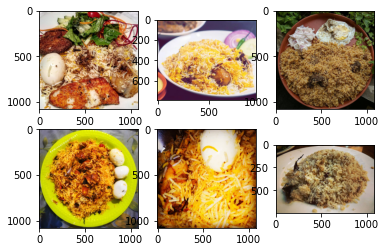

In [73]:
import numpy as np # linear algebra
from PIL import Image
import matplotlib.pyplot as plt

#img_array = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (2).jpg'))
#plt.imshow(img_array)

img_array0 = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (2).jpg'))
img_array1 = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (4).jpg'))
img_array2 = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (7).jpg'))
img_array3 = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (9).jpg'))
img_array4 = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (22).jpg'))
img_array5 = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (24).jpg'))
array_img = [img_array0, img_array1, img_array2, img_array3, img_array4, img_array5]

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(array_img[i])
plt.show()

### Predicting Output Class for Single Image

noodles


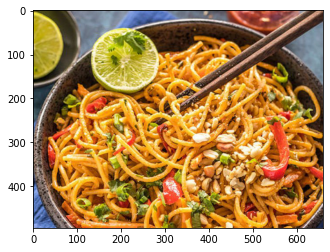

In [139]:
#img = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (2).jpg'))
img = Image.open('./food20dataset/test_set/noodles/noodlestest (30).jpg')
plt.imshow(img)

#apply transforms
inp = transform(img).unsqueeze(0)
#inp = inp.cuda()

#set the network on evaluation mode
net.eval()
net = net.cpu()

# Predict the output class of the input passed to the net
out = net(inp)
index = out.data.numpy().argmax()
print(class_names[index])

#print(out.shape)

#out = out.cpu()
#out = out.detach()
#pred = torch.argmax(out, dim=1)
#predicted_class = np.argmax(out)

#import torch.nn.functional as F
#prob = F.softmax(out, dim=1)
#print(prob)

# **Image Segmentation**

In [108]:
# Define the helper function
def decode_segmap(image, nc=21):
  
  label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  
  for l in range(0, nc):
    idx = image == l
    r[idx] = label_colors[l, 0]
    g[idx] = label_colors[l, 1]
    b[idx] = label_colors[l, 2]
    
  rgb = np.stack([r, g, b], axis=2)
  return rgb

### Load an FCN & an Image

torch.Size([1, 21, 299, 299])


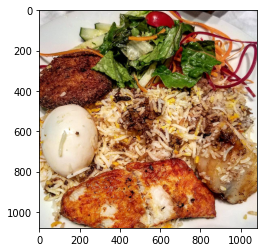

In [154]:
#load fully convolution network & set to evaluation mode
fcn = models.segmentation.fcn_resnet101(pretrained=True).eval()      #FCN Resnet101   #fcn.cuda()
#fcn = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()   #DeepLabV3 Resnet101


#load image
#img = np.array(Image.open('./food20dataset/test_set/biriyani/biriyanitest (2).jpg'))
img = Image.open('./food20dataset/test_set/biriyani/biriyanitest (2).jpg')
plt.imshow(img)

#apply transforms
inp = transform(img).unsqueeze(0)   #inp = inp.cuda()


# Pass the input through the net
out = fcn(inp)['out']
print (out.shape)

### Predict the Segment Map of the Image

(299, 299)
[ 0 11]


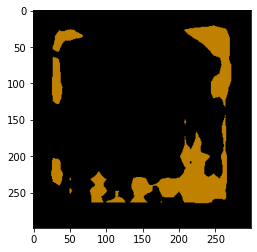

In [155]:
import numpy as np
om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
print (om.shape)
print (np.unique(om))

rgb = decode_segmap(om)
plt.imshow(rgb); plt.show()